<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Selected Features (FW)</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
# load the best features dictionaries back from the file
with open('../../data/selected_features/feature_set_01_filter_and_wrapper.json', 'r') as json_file:
    selected_features_filter_and_wrapper = json.load(json_file)

with open('../../data/selected_features/feature_set_02_embedded.json', 'r') as json_file:
    selected_features_embedded = json.load(json_file)

In [5]:
# subset the features
pts_sub_fw_features = pts_all_features[selected_features_filter_and_wrapper['TOTAL_PTS'] + ['TOTAL_PTS']]
pts_sub_e_features = pts_all_features[selected_features_embedded['TOTAL_PTS'] + ['TOTAL_PTS']]

pm_sub_fw_features = pm_all_features[selected_features_filter_and_wrapper['PLUS_MINUS'] + ['PLUS_MINUS']]
pm_sub_e_features = pm_all_features[selected_features_embedded['PLUS_MINUS'] + ['PLUS_MINUS']]

res_sub_fw_features = res_all_features[selected_features_filter_and_wrapper['GAME_RESULT'] + ['GAME_RESULT']]
res_sub_e_features = res_all_features[selected_features_embedded['GAME_RESULT'] + ['GAME_RESULT']]

In [6]:
pts_sub_fw_features.head()

,ROLL_HOME_FTM,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_PTS_PAINT,ROLL_AWAY_PTS,ROLL_HOME_PTS_FB,ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED,ROLL_AWAY_DEF_BOXOUTS,ROLL_AWAY_estimatedPace,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_DFG_PCT,ROLL_HOME_AST,ROLL_AWAY_assistToTurnover,ROLL_HOME_OPP_TOV_PCT,ROLL_HOME_estimatedDefensiveRating,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,
2021-10-23,0.955,0.814,0.50,0.577,1.000,0.60,0.20,0.367,0.391,1.000,0.667,0.349,0.840,0.337,185
2021-10-23,0.553,0.763,0.25,0.096,0.581,0.30,0.30,0.458,0.000,0.440,0.000,0.193,0.762,0.199,198
2021-10-23,0.704,0.508,0.70,0.635,0.065,0.75,0.20,0.393,0.565,0.000,0.611,0.705,0.144,0.809,239
2021-10-23,0.352,0.610,0.70,0.250,0.839,0.30,0.10,0.649,0.261,0.964,1.000,0.261,0.519,0.370,232
2021-10-24,0.302,0.203,0.70,1.000,0.548,0.45,0.45,0.598,0.348,0.726,0.833,0.471,0.591,0.003,204


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [7]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_sub_fw_features.drop('TOTAL_PTS', axis=1),
    pts_sub_fw_features['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 14) (2367,) (691, 14) (691,)


In [8]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 123.97 seconds


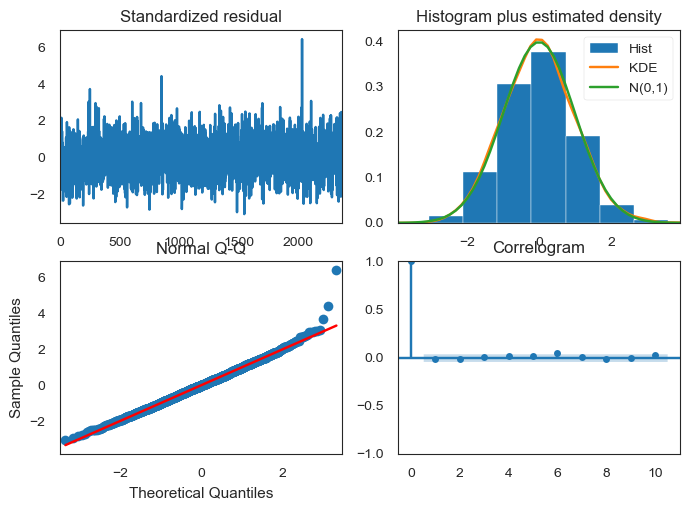

In [9]:
model1.plot_diagnostics();

In [10]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:                        SARIMAX   Log Likelihood              -10299.578
Date:                Tue, 09 Apr 2024   AIC                          20631.157
Time:                        23:11:35   BIC                          20723.467
Sample:                             0   HQIC                         20664.763
                               - 2367                                         
Covariance Type:                  opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
intercept                             182.6412      5.471     33.380      0.000     171.917     193.365
ROLL_HOME_FTM                           8.5806      3.233      2.654      0.008       2.243      14.918
ROLL_HOME_OPP_PTS_PAINT                11.2108      3.503      3.200      0.001       4.344      18.077
ROLL_HOME_PTS_PAINT                     7.8299      3.246      2.413      0.016       1.469      14.191
ROLL_AWAY_PTS                          12.5997      4.762      2.646      0.008       3.267      21.933
ROLL_HOME_PTS_FB                       11.8452      3.768      3.143      0.002       4.459      19.231
ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED    -2.2476      3.930     -0.572      0.567      -9.951       5.456
ROLL_AWAY_DEF_BOXOUTS                 -16.7696      4.978     -3.368      0.001     -26.527      -7.012
ROLL_AWAY_estimatedPace                18.1559      3.796      4.783      0.000      10.715      25.596
ROLL_AWAY_PTS_PAINT                    -0.3038      4.163     -0.073      0.942      -8.463       7.856
ROLL_AWAY_DFG_PCT                       4.8535      3.739      1.298      0.194      -2.475      12.182
ROLL_HOME_AST                           8.7565      3.082      2.841      0.004       2.716      14.797
ROLL_AWAY_assistToTurnover              6.8952      4.050      1.703      0.089      -1.043      14.833
ROLL_HOME_OPP_TOV_PCT                 -14.7778      4.463     -3.311      0.001     -23.525      -6.031
ROLL_HOME_estimatedDefensiveRating     12.5441      3.582      3.502      0.000       5.524      19.564
sigma2                                352.3349      9.177     38.392      0.000     334.348     370.322
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                70.15
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.22
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.62 %
Root Mean Squared Error: 19.06


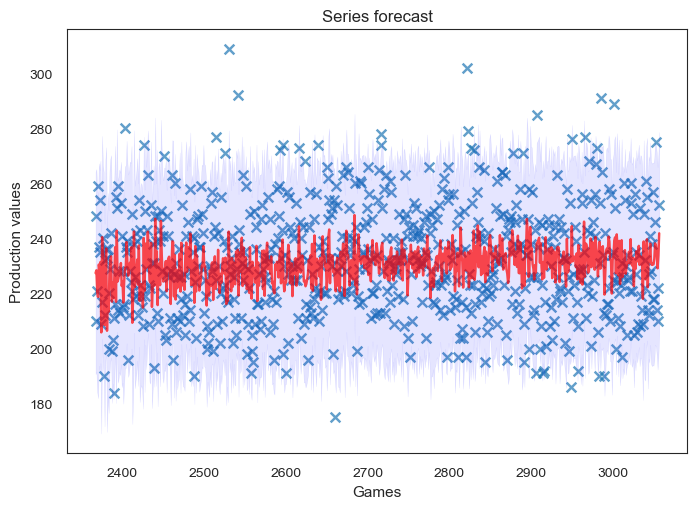

In [12]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_sub_fw_features['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [13]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_sub_fw_features.drop('PLUS_MINUS', axis=1),
    pm_sub_fw_features['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 8) (2367,) (691, 8) (691,)


In [14]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 23.40 seconds


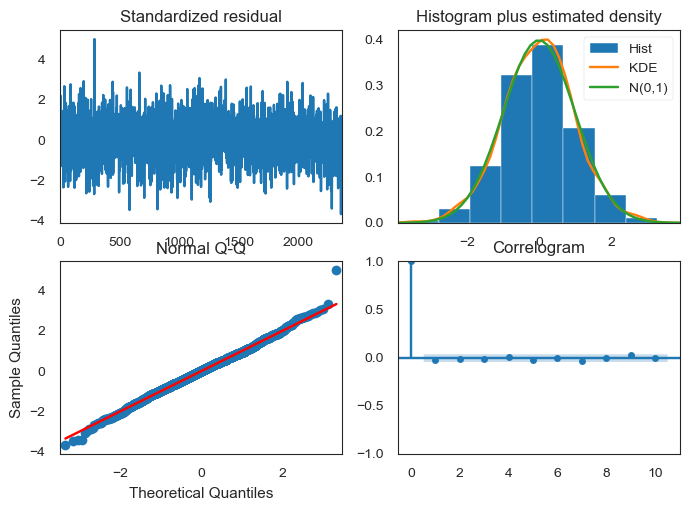

In [15]:
model1.plot_diagnostics();

In [16]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:                        SARIMAX   Log Likelihood               -9576.619
Date:                Tue, 09 Apr 2024   AIC                          19171.237
Time:                        23:12:00   BIC                          19223.162
Sample:                             0   HQIC                         19190.141
                               - 2367                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ROLLDIFF_AWAY_STL           -2.8395      1.678     -1.692      0.091      -6.128       0.449
ROLL_HOME_CFG_PCT            2.6058      2.189      1.190      0.234      -1.685       6.897
ROLL_AWAY_OPP_PTS_PAINT      5.1595      2.238      2.306      0.021       0.773       9.546
ROLLDIFF_AWAY_PTS          -15.3325      2.427     -6.316      0.000     -20.090     -10.575
ROLLDIFF_HOME_PTS           18.7313      2.180      8.591      0.000      14.458      23.005
ROLL_HOME_SCREEN_ASSISTS     1.5090      2.997      0.504      0.615      -4.365       7.383
ROLLDIFF_AWAY_AST           -1.6821      1.925     -0.874      0.382      -5.456       2.091
ROLL_HOME_CFGA              -5.7914      1.881     -3.080      0.002      -9.477      -2.106
sigma2                     191.3107      5.095     37.552      0.000     181.326     201.296
===================================================================================
Ljung-Box (L1) (Q):                   1.71   Jarque-Bera (JB):                19.45
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 136.28 %
Root Mean Squared Error: 14.28


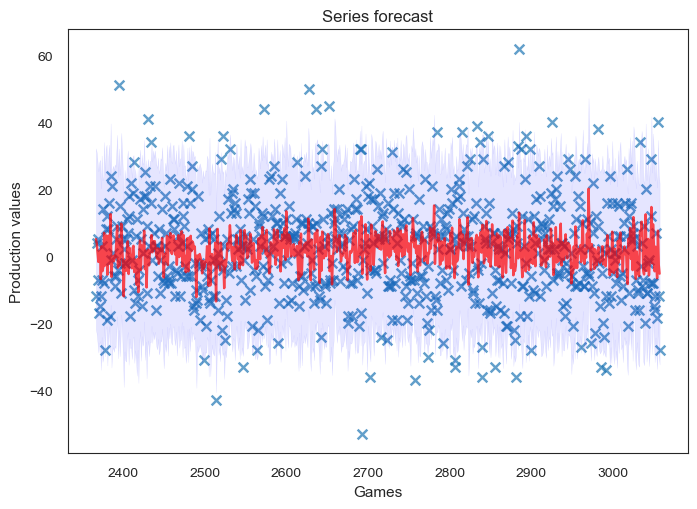

In [18]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pm_sub_fw_features['PLUS_MINUS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();